In [1]:
import copy
import numpy as np

In [2]:
import matplotlib.gridspec as gridspec

import palettable

In [3]:
import verdict

In [4]:
import stained_glass.idealized as idealized
import stained_glass.stats as stats
import stained_glass.sample as sample

# Parameters

In [5]:
# Number of sightlines
n = 5000
r_clump = 0.2
edges_log = np.logspace( -2., np.log10( 20. ), 16 )
edges = np.linspace( 0., 20., 16 )

In [6]:
# Choose statistics
statistics = {
    'TPCF LS': {
        'fn': stats.two_point_autocf,
        'fnkwargs': { 'estimator': 'ls' },
    },
    'TPCF simple': {
        'fn': stats.two_point_autocf,
        'fnkwargs': { 'estimator': 'simple' },
    },
    'TPCF LS-radial': {
        'fn': stats.two_point_autocf,
        'fnkwargs': { 'estimator': 'ls' },
        'radial': True,
    },
    'TPCF simple-radial': {
        'fn': stats.two_point_autocf,
        'fnkwargs': { 'estimator': 'simple' },
        'radial': True,
    },
}

In [7]:
xs = edges[:-1] + 0.5 * ( edges[1] - edges[0] )

In [8]:
xs_log = 10.**( np.log10( edges_log[:-1] ) + 0.5 * ( np.log10( edges_log[1] ) - np.log10( edges_log[0] ) ) )

##### DEBUG
xs_log = xs
edges_log = edges

# Setup idealized projections

In [9]:
ips = []

In [10]:
# Radial distribution
ip = idealized.IdealizedProjection()
ip.add_ellipse(
    c = (0., 0.),
    a = 3.,
    value = 4,
)

structs, values = copy.copy( ip.structs ), copy.copy( ip.struct_values )
for struct, value in zip( *[ structs, values ] ):
    ip.add_concentric_structures(
        struct,
        value = value,
        n_concentric = 4,
    )

ips.append( ip )

In [11]:
# Radial distribution and satellite
ip = idealized.IdealizedProjection()
ip.add_ellipse(
    c = (0., 0.),
    a = 3.,
    value = 5,
)
ip.add_ellipse(
    c = (6., 6.),
    a = 1.5,
    value = 4,
)

structs, values = copy.copy( ip.structs ), copy.copy( ip.struct_values )
for struct, value in zip( *[ structs, values ] ):
    ip.add_concentric_structures(
        struct,
        value = value,
        n_concentric = 4,
    )

ips.append( ip )

In [12]:
# Clumps
ip = idealized.IdealizedProjection()
ip.add_clumps(
    r_clump = r_clump,
    c = (0., 0.),
    r_area = 5.,
    fcov = 0.5,
    value = 4,
)

structs, values = copy.copy( ip.structs ), copy.copy( ip.struct_values )
for struct, value in zip( *[ structs, values ] ):
    ip.add_concentric_structures(
        struct,
        value = value,
        n_concentric = 4,
        dr = 0.3,
    )

ips.append( ip )

In [13]:
# Filament
ip = idealized.IdealizedProjection()
ip.add_curve(
    v1 = (0., 0.),
    v2 = (-10., 2.),
    theta_a = 20.,
    theta_b = 60.,
    value = 4,
)

structs, values = copy.copy( ip.structs ), copy.copy( ip.struct_values )
for struct, value in zip( *[ structs, values ] ):
    ip.add_concentric_structures(
        struct,
        value = value,
        n_concentric = 4,
    )

ips.append( ip )

In [14]:
# All of the above
ip = idealized.IdealizedProjection()
ip.add_ellipse(
    c = (0., 0.),
    a = 3.,
    value = 4,
)
ip.add_ellipse(
    c = (6., 6.),
    a = 2.,
    value = 4,
)
ip.add_clumps(
    r_clump = r_clump,
    c = (0., 0.),
    r_area = 5.,
    fcov = 0.5,
    value = 4,
)
ip.add_curve(
    v1 = (0., 0.),
    v2 = (-10., 2.),
    theta_a = 20.,
    theta_b = 60.,
    value = 4,
)

structs, values = copy.copy( ip.structs ), copy.copy( ip.struct_values )
for struct, value in zip( *[ structs, values ] ):
    ip.add_concentric_structures(
        struct,
        value = value,
        n_concentric = 4,
    )

ips.append( ip )

In [15]:
# Add backgrounds
[ ip.add_background( 0 ) for ip in ips ]

[None, None, None, None, None]

In [16]:
# Generate Projections
[ ip.generate_idealized_projection() for ip in ips ]

[None, None, None, None, None]

# Calculate Metrics

In [17]:
all_tpcfs = {}

### Calculate weighted TPCF

In [18]:
tpcfs = []
means = []
for i, ip in enumerate( ips ):
    
    # Get data
    ip.generate_sightlines( n )
    ws = ip.evaluate_sightlines()
    coords = np.array([ ip.sl_xs, ip.sl_ys ]).transpose()
    
    tpcf, edges = stats.weighted_tpcf(
        coords,
        ws,
        edges_log,
    )
    
    tpcfs.append( tpcf )
    
    # Store the fiducially-sampled mean for more consistent normalization later
    means.append( np.nanmean( ws ) )
    
all_tpcfs[( 'W', )] = tpcfs

### Calculate radially-normalized, weighted TPCF

In [19]:
tpcfs = []
for i, ip in enumerate( ips ):
    
    # Get data
    ip.generate_sightlines( n )
    ws = ip.evaluate_sightlines()
    coords = np.array([ ip.sl_xs, ip.sl_ys ]).transpose()
    
    tpcf, edges = stats.radial_weighted_tpcf(
        coords,
        ws,
        edges_log,
    )
    
    tpcfs.append( tpcf )
    
all_tpcfs[( 'RN', 'W', )] = tpcfs

### Generate Paired Coordinates

In [20]:
v_edges = np.array([ ip.ip_values.min(), ip.ip_values.max() ])

In [21]:
pair_sampler = sample.PairSampler( ip.sidelength, edges_log, v_edges )
dr_coords1, dr_coords2 = pair_sampler.generate_pair_sampling_coords(
    n_per_bin = round( n / (edges_log.size - 1 ) / 2 ),
)

In [22]:
pair_coords = np.concatenate([ np.concatenate( dr_coords1 ), np.concatenate( dr_coords2 ) ])

In [38]:
# Get the normalizations using the means from non-paired sampling
means = np.array( means )
normalizations = means ** -2.

### Calculate radially-normalized, pair-sampled, weighted TPCF

In [24]:
tpcfs = []
for i, ip in enumerate( ips ):
    
    # Get data
    ip.set_sightlines( pair_coords )
    ws = ip.evaluate_sightlines()
    
    tpcf, edges = stats.radial_weighted_tpcf(
        pair_coords,
        ws,
        edges_log,
        normalization = normalizations[i],
    )
    
    tpcfs.append( tpcf )
    
all_tpcfs[( 'RN', 'PS', 'W', )] = tpcfs

### Calculate pair-sampled, weighted TPCF

In [25]:
tpcfs = []
for i, ip in enumerate( ips ):
    
    # Get data
    ip.set_sightlines( pair_coords )
    ws = ip.evaluate_sightlines()
    
    tpcf, edges = stats.weighted_tpcf(
        pair_coords,
        ws,
        edges_log,
        normalization = normalizations[i],
    )
    
    tpcfs.append( tpcf )
    
all_tpcfs[( 'PS', 'W', )] = tpcfs

# Plot the Different Metrics

In [26]:
all_tpcfs = verdict.Dict( all_tpcfs )

In [27]:
global_min = all_tpcfs.apply( np.array ).apply( np.nanmin ).keymin()[1]
global_max = all_tpcfs.apply( np.array ).apply( np.nanmax ).keymax()[1]

In [28]:
ncols = len( ips )
nrows = 2

In [29]:
colors = palettable.cartocolors.qualitative.Safe_10.mpl_colors

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


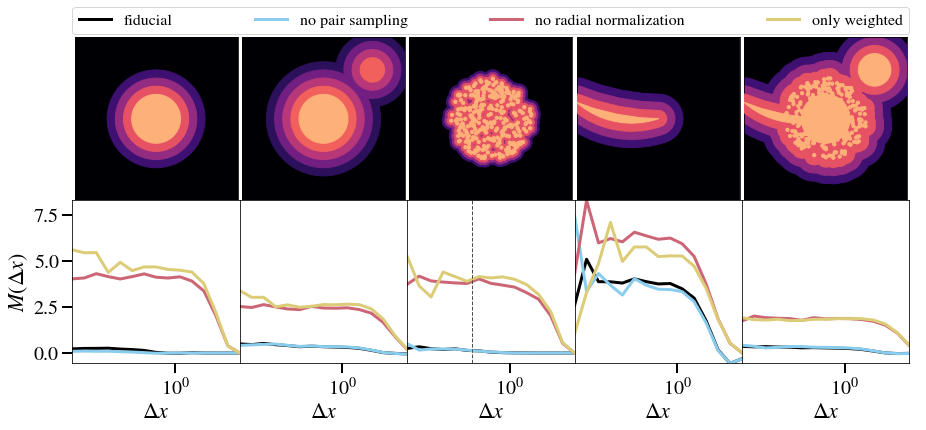

In [35]:
fig = plt.figure( figsize=(3*ncols, 3*nrows), facecolor='w' )
ax = plt.gca()

gs = gridspec.GridSpec( nrows, ncols )
gs.update( wspace=0.0001, hspace=0.0001 )

for i, ip in enumerate( ips ):
    
    # Plot the idealized image
    ax = plt.subplot( gs[0,i], )
    ip.plot_idealized_projection(
        ax,
    )
    
    # Fiducial
    ax = plt.subplot( gs[1,i], )
        
    # Plot Fiducial
    tpcf = all_tpcfs[( 'RN', 'PS', 'W', )][i]
    ax.plot(
        xs_log,
        tpcf,
        linewidth = 3,
        color = 'k',
        label = r'fiducial'
    )
    
    # Plot w/o pair-sampling
    tpcf = all_tpcfs[( 'RN', 'W', )][i]
    ax.plot(
        xs_log,
        tpcf,
        linewidth = 3,
        color = colors[0],
        label = r'no pair sampling',
    )
    
    # Plot w/o radial normalization
    tpcf = all_tpcfs[( 'PS', 'W', )][i]
    ax.plot(
        xs_log,
        tpcf,
        linewidth = 3,
        color = colors[1],
        label = r'no radial normalization',
    )
    
    # Plot only weighted
    tpcf = all_tpcfs[( 'W', )][i]
    ax.plot(
        xs_log,
        tpcf,
        linewidth = 3,
        color = colors[2],
        label = r'only weighted',
    )
        
    # Clump line
    if i == 2:
        ax.axvline(
            r_clump,
            linewidth = 1.,
            color = '.3',
            linestyle = '--',
        )
        
# Go back through and fix up axes
for i in range( ncols ):
    for j in range( nrows ):
        
        ax = plt.subplot( gs[j,i], )
        
        # Projection Plot options
        if j < 1:
            
            ax.set_aspect( 'equal' )
            ax.tick_params( labelleft=False, labelbottom=False, left=False, bottom=False)
            
        # Statistics options
        if j >= 1:
            
            # Remove tick labels
            if not ax.is_first_col():
                ax.tick_params( labelleft=False, left=False, )
            if not ax.is_last_row():
                ax.tick_params( labelbottom=False, bottom=False )
            
            # Limits for statistics
            ax.set_xlim( xs_log[0], xs_log[-1] )
            ax.set_ylim( global_min, global_max )
            
            ax.set_xscale( 'log' )
#             ax.set_yscale( 'log' )
            
            ax.set_xlabel( r'$\Delta x$', fontsize=22 )
            if ax.is_first_col():
                ax.set_ylabel( r'$M(\Delta x)$', fontsize=22 )
          
            # Legend
            if ax.is_first_col():
                ax.legend(
                    bbox_to_anchor = (0.0, 2.02, 5., 0.5 ),
                    loc = 'lower left',
                    ncol = 4,
                    mode = "expand",
                    borderaxespad = 0.,
                    prop = {'size': 16},
                )

The multiple-per-halo statistics to consider are
[Radially-normalized], [pair-sampled], [weighted] TPCF [per cut on N].

The default should be with everything except for the N bins turned on.

One row will show the effect of turning on/off pair sampling (should be log-spaced).

One row will show the effect of turning on/off N bins.

One row will show the effect of turning on/off radial-normalization and weighting.